# **Step 1: Load Data and Import Library**

In [1]:
import pandas as pd
import json
from pandas import DataFrame
!pip install pyvi
from pyvi import ViTokenizer, ViPosTagger
from pyvi import ViUtils
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd 
import io 
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, log_loss
from tabulate import tabulate
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from nltk.corpus import stopwords

import os
import csv

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


     |████████████████████████████████| 8.5 MB 11.0 MB/s 
     |████████████████████████████████| 743 kB 16.2 MB/s 
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
/kaggle/input/mercari-price-suggestion-challenge/test.tsv.7z
/kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
/kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip
/kaggle/input/mercari-price-suggestion-challenge/sample_submission.csv.7z


In [2]:
!apt-get install p7zip
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/test.tsv.7z
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/sample_submission.csv.7z




Suggested packages:
  p7zip-full
The following NEW packages will be installed:
  p7zip
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 358 kB of archives.
After this operation, 996 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip amd64 16.02+dfsg-6 [358 kB]
Fetched 358 kB in 0s (2191 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package p7zip.
(Reading database ... 95327 files and directories currently installed.)
Preparing to unpack .../p7zip_16.02+dfsg-6_amd64.deb ...
Unpacking p7zip (16.02+dfsg-6) ...
Setting up p7zip (16.02+dfsg-6) ...

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /kaggle/input/mercari-price-suggestion-challenge/

In [3]:
!unzip /kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
!unzip /kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip

Archive:  /kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
  inflating: sample_submission_stg2.csv  
Archive:  /kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip
  inflating: test_stg2.tsv           


In [4]:
train_data = pd.read_csv('train.tsv', sep='\t')
test_data = pd.read_csv('test_stg2.tsv', sep='\t')
print(train_data.shape)
print(test_data.shape)
print(train_data.columns)
print(test_data.columns)

(1482535, 8)
(3460725, 7)
Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')
Index(['test_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'shipping', 'item_description'],
      dtype='object')


In [5]:
train_data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [6]:
test_data.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


# **Step 2: Data Preprocessing**

**2.1. Check for Duplicates**

In [7]:
print('Number of duplicates in train: {}'.format(sum(train_data.duplicated())))
print('Number of duplicates in test : {}'.format(sum(test_data.duplicated())))

Number of duplicates in train: 0
Number of duplicates in test : 0


**2.2. Checking for NaN/null values**

In [8]:
train_data.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool

In [9]:
print('{} NaN/Null values in train'.format(train_data.isnull().values.sum()))
print('{} NaN/Null values in test'.format(test_data.isnull().values.sum()))

639013 NaN/Null values in train
1491329 NaN/Null values in test


In [10]:
# train_data["category_name"] = train_data["category_name"].fillna("Other").astype("category")
train_data["brand_name"] = train_data["brand_name"].fillna("unknown")
train_data["item_description"] = train_data["item_description"].fillna("None")
train_data["brand_name"] = train_data["brand_name"].astype("category")

# test_data["category_name"] = test_data["category_name"].fillna("Other").astype("category")
test_data["brand_name"] = test_data["brand_name"].fillna("unknown")
test_data["item_description"] = test_data["item_description"].fillna("None")
test_data["brand_name"] = test_data["brand_name"].astype("category")

In [11]:
train_copy = train_data.copy()
test_copy = test_data.copy()

**2.3. Encoder**

In [12]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")
    
def create_split_categories(data):
    data['main_category'],data['subcat_1'],data['subcat_2']=zip(*data['category_name'].apply(lambda x: split_cat(x)))

def toNumeric(frame, data,to):
    le = preprocessing.LabelEncoder()
    frame[to] = le.fit_transform(frame[data].astype(str))
    
def split_cat_encoder(frame):
    toNumeric(frame, 'main_category', 'main_category' )
    toNumeric(frame, 'subcat_1', 'subcat_1' )
    toNumeric(frame, 'subcat_2', 'subcat_2' )
    
def data_frame_encoder(frame):
    toNumeric(frame, 'category_name', 'category_name' )
    toNumeric(frame, 'item_description', 'item_description' )
    toNumeric(frame, 'name', 'name' )
    toNumeric(frame, 'brand_name', 'brand_name' )
    
def divide_cats(data):
    if(0<= data <=1):
        return "CAT1"
    if(1 < data <= 2):
        return "CAT2"
    if(2 < data <= 3):
        return "CAT3"
    if(3 < data <= 4):
        return "CAT4"
    if(4 < data <= 5):
        return "CAT5"
    if(5< data <=6):
        return "CAT6"
    if(6 < data <= 7):
        return "CAT7"
    return "CATOTHER"

def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stopwords.words('english')])
    return x

In [13]:
create_split_categories(train_copy)
train_copy['log_price'] = train_copy['price'].map(lambda x: np.log(x) if x>0 else x)
train_copy['price_cats'] = train_copy['log_price'].map(lambda x : divide_cats(x))


test_copy = test_data.copy()
create_split_categories(test_copy)

In [14]:
train_copy.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,subcat_1,subcat_2,log_price,price_cats
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,unknown,10.0,1,No description yet,Men,Tops,T-shirts,2.302585,CAT3
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3.951244,CAT4
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,2.302585,CAT3
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,unknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,3.555348,CAT4
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,unknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3.784190,CAT4
5,5,Bundled items requested for Ruie,3,Women/Other/Other,unknown,59.0,0,"Banana republic bottoms, Candies skirt with ma...",Women,Other,Other,4.077537,CAT5
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...,Women,Swimwear,Two-Piece,4.158883,CAT5
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...,Sports & Outdoors,Apparel,Girls,1.791759,CAT2
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.,Sports & Outdoors,Apparel,Girls,2.944439,CAT3
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,unknown,8.0,0,I realized his pants are on backwards after th...,Vintage & Collectibles,Collectibles,Doll,2.079442,CAT3


In [15]:
split_cat_encoder(train_copy)
data_frame_encoder(train_copy)

split_cat_encoder(test_copy)
data_frame_encoder(test_copy)

In [16]:
train_copy.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,subcat_1,subcat_2,log_price,price_cats
0,0,640809,3,808,4807,10.0,1,806610,5,103,763,2.302585,CAT3
1,1,903932,3,86,3557,52.0,0,1090878,1,30,212,3.951244,CAT4
2,2,91532,1,1254,4180,10.0,1,115289,10,104,94,2.302585,CAT3
3,3,561143,1,485,4807,35.0,1,782305,3,55,404,3.555348,CAT4
4,4,45483,1,1181,4807,44.0,0,366652,10,58,536,3.784190,CAT4


In [17]:
test_copy.head(5)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,main_category,subcat_1,subcat_2
0,0,497322,1,1230,5859,1,2189482,10,58,674
1,1,100830,1,916,5859,1,150218,7,72,709
2,2,629168,1,1018,1216,1,601498,9,7,384
3,3,836033,2,1281,5859,0,53732,10,97,167
4,4,1243301,3,878,5859,1,2064967,7,14,669


# **Step 3 : Exploratory Data Analysis**

In [18]:
train_copy.price.describe() # std do lech chuan

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

**Sale Price**

 Range of price :  $ 0.0  -  $ 2009.0


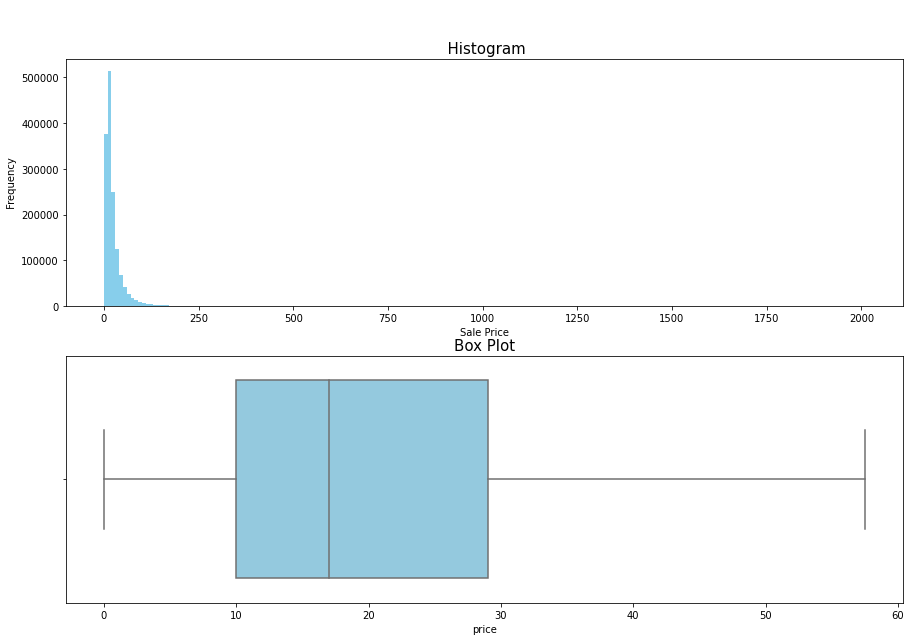

In [19]:
print(" Range of price : ",'$',train_copy["price"].min(), ' - ','$',train_copy["price"].max())
fig, ax = plt.subplots(2, 1, figsize = (15, 10))
ax[0].hist(train_copy.price, bins = 200, range = [min(train_copy.price), max(train_copy.price)], label = "price",color = "skyblue")
ax[0].set_title("\n \n  Histogram ", fontsize = 15)
ax[0].set_xlabel("Sale Price", fontsize = 10)
ax[0].set_ylabel(" Frequency ", fontsize = 10)
sns.boxplot(train_copy.price, showfliers = False, ax = ax[1],color = "skyblue")
ax[1].set_title("Box Plot", fontsize = 15)
plt.show()

Giá các sản phẩm rơi nhiều vào khoảng 10 đến 30, trong đó lệch về 10 nhiều hơn, có sự xuất hiện của các sản phẩm có giá 0 (do người bán muốn tặng hoặc bán miễn phí).

**Log Price**

 Range of price :  $ 0.0  -  $ 7.605392364814935


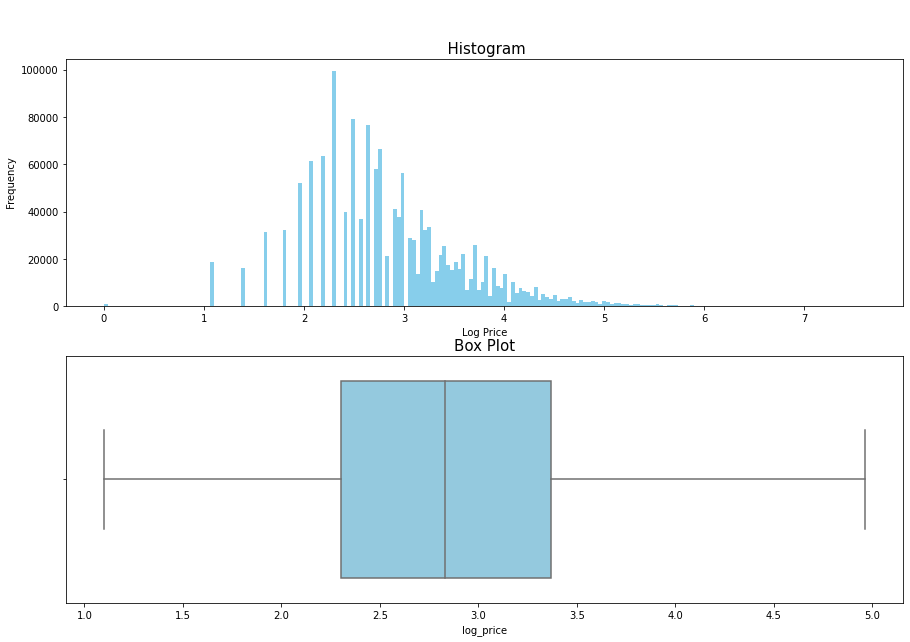

In [20]:
print(" Range of price : ",'$',train_copy["log_price"].min(), ' - ','$',train_copy["log_price"].max())
fig, ax = plt.subplots(2, 1, figsize = (15, 10))
ax[0].hist(train_copy.log_price, bins = 200, range = [min(train_copy.log_price), max(train_copy.log_price)], label = "log_price",color = "skyblue")
ax[0].set_title("\n \n  Histogram ", fontsize = 15)
ax[0].set_xlabel("Log Price", fontsize = 10)
ax[0].set_ylabel(" Frequency ", fontsize = 10)
sns.boxplot(train_copy.log_price, showfliers = False, ax = ax[1],color = "skyblue")
ax[1].set_title("Box Plot", fontsize = 15)
plt.show()

Giá các sản phẩm rơi nhiều vào khoảng 2 đến 4.

Việc lấy log cho price giúp price sẽ được phân bố đồng đều hơn so với việc để nguyên price. Có thể thấy rõ qua Range of price, trong khi Range of price của price là từ $ 0.0  -  $ 2009.0 thì Range of price của log_price chỉ là từ $ 0.0  -  $ 7.60. Việc chênh lệch quá lớn của price (nếu không lấy log) sẽ khiến cho model gặp khó khăn trong việc training, khiến cho model không còn chính xác nữa. Do đó, chúng tôi sẽ chọn log_price thay thế cho price trong quá trình training các model.

**Brand Name**

Unique Brand Names : 4810


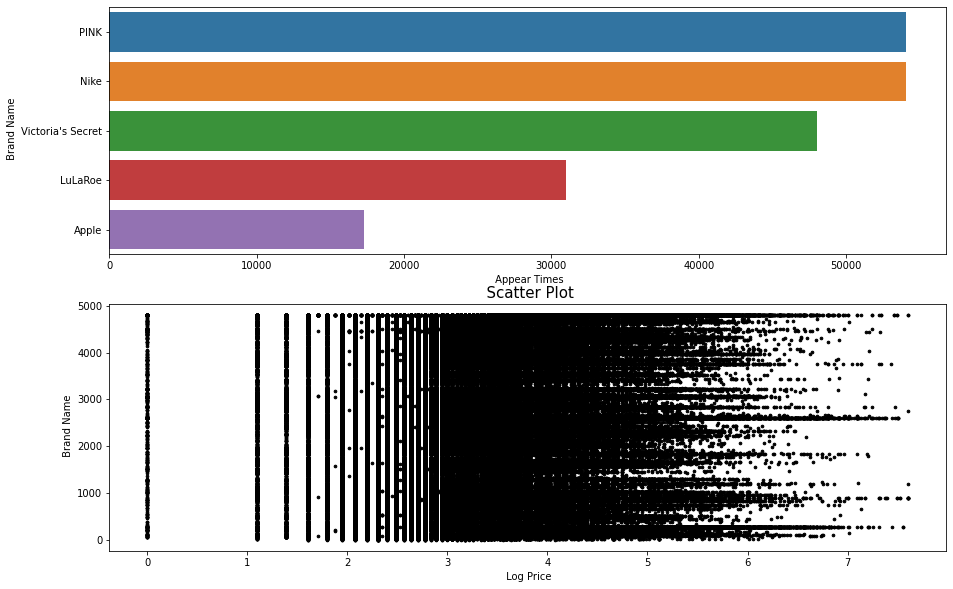

In [21]:
# barplot biểu diễn mật độ xuất hiện của các brand name
# scarterplot biểu dễn giá của từng từng sản phảm thuộc từng brand name dưới dạng numberic (index)
brands = train_data["brand_name"].value_counts()
print("Unique Brand Names :", brands.size)
brands_key = []
for i in range(0,5):
    brands_key.append(brands[1:6].keys()[i])
fig, ax = plt.subplots(2, 1, figsize = (15, 10))
sns.barplot(brands[1:6].values, brands_key , ax = ax[0]) #brand[0] có nhãn "-1"
f1 = train_copy['log_price'].values
f2 = train_copy['brand_name'].values

f3 = train_copy['price'].values
f4 = train_copy['brand_name'].values

ax[1].set_title("\n \n  Scatter Plot ", fontsize = 15)
ax[1].scatter(f1, f2, c='black', s = 7)# s là size của scatter
ax[0].set_xlabel(" Appear Times", fontsize = 10)
ax[0].set_ylabel(" Brand Name", fontsize = 10)
ax[1].set_xlabel(" Log Price", fontsize = 10)
ax[1].set_ylabel(" Brand Name", fontsize = 10)

plt.show()

**Item Condition ID**

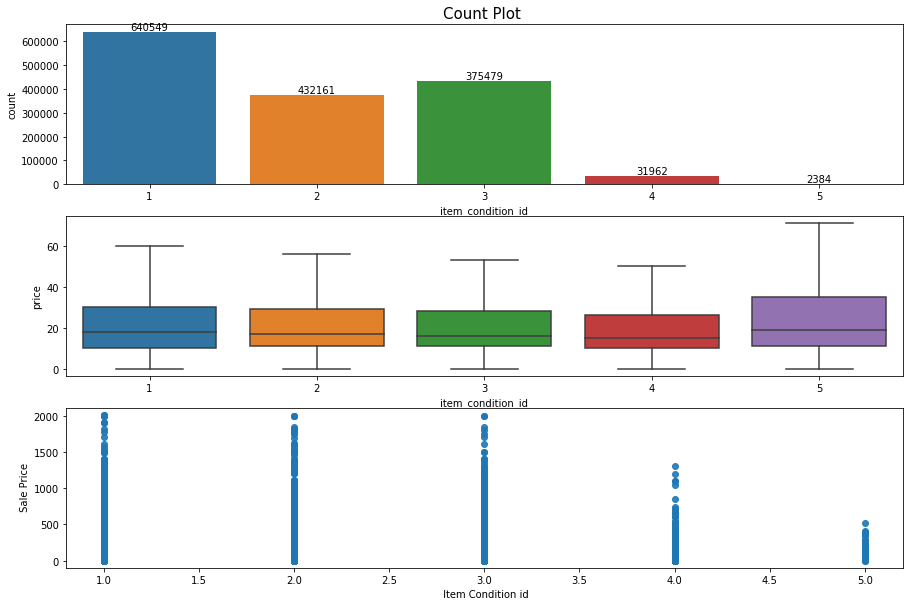

In [22]:
fig, ax = plt.subplots(3, 1, figsize = (15,10))
sns.countplot(train_copy.item_condition_id, ax = ax[0])
rectangles = ax[0].patches
ax[0].set_title("Count Plot ", fontsize = 15)
labels = train_copy.item_condition_id.value_counts().values
for rect, label in zip(rectangles, labels):#đưa số lần xuất hiện lên đầu các cột
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width()/2, height + 5, label, ha = "center", va = "bottom")
    
sns.boxplot(x = train_copy.item_condition_id, y = train_copy.price,showfliers = False, orient = "v", ax = ax[1])
ax[2].scatter(x = train_copy.item_condition_id, y = train_copy.price,alpha=0.9)
ax[2].set_xlabel(" Item Condition id", fontsize = 10)
ax[2].set_ylabel(" Sale Price", fontsize = 10)
plt.show()

**Shipping**

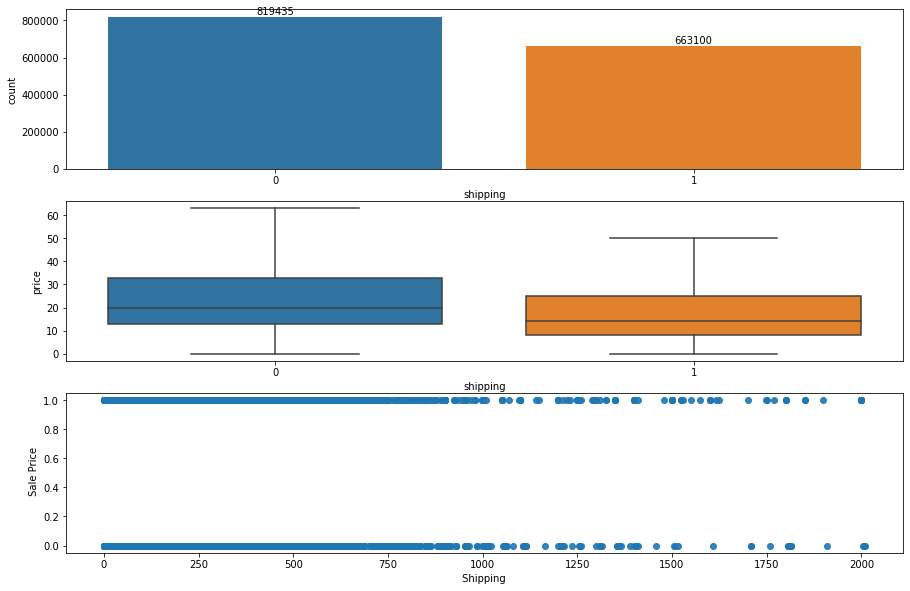

In [23]:
fig, ax = plt.subplots(3, 1, figsize = (15,10))
sns.countplot(train_copy.shipping, ax = ax[0])
rectangles = ax[0].patches
labels = train_copy.shipping.value_counts().values
for rect, label in zip(rectangles, labels):
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width()/2, height + 5, label, ha = "center", va = "bottom")
sns.boxplot(x = train_copy.shipping, y = train_copy.price,showfliers = False, orient = "v", ax = ax[1])
ax[2].scatter(x = train_copy.price, y = train_copy.shipping,alpha=0.9)
ax[2].set_xlabel(" Shipping ", fontsize = 10)
ax[2].set_ylabel(" Sale Price", fontsize = 10)
plt.show()

# **Step 4 : Data Modeling**

# **Model 1. Linear Regreession**

Text(0.5, 0.98, ' Correlations Heat Map for attributes')

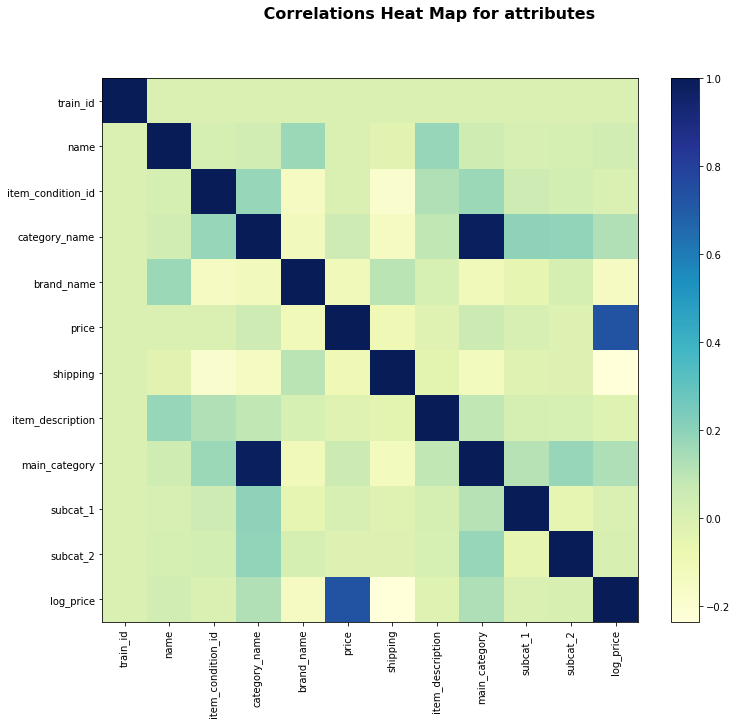

In [24]:
corltn=train_copy.corr() #tính độ tương quan giữa các cột, bỏ qua giá trị null
corltn=corltn.fillna(0)
plt.figure(figsize=(12, 10))
plt.imshow(corltn, cmap='YlGnBu', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corltn)), corltn.columns, rotation='vertical')
plt.yticks(range(len(corltn)), corltn.columns);
plt.suptitle(' Correlations Heat Map for attributes', fontsize=16, fontweight='bold')

Không có sự tương quan rõ ràng giữa cột giá và các cột khác để sử dụng để dự 
báo.

**Using Category_name**

In [25]:
X_train, x_test, Y_train, y_test = train_test_split(
train_copy['main_category'], train_copy['log_price'], test_size=0.2, random_state=42) #tách thành 2 tập test và train 
regr_0 = linear_model.LinearRegression()
X_train = X_train[:, np.newaxis] # reshape 2D array into 1D array
Y_train = Y_train[:, np.newaxis]  # reshape 2D array into 1D array
x_test = x_test[:, np.newaxis]  # reshape 2D array into 1D array
y_test = y_test[:, np.newaxis]  # reshape 2D array into 1D array
regr_0.fit(X_train, Y_train)

y_train_predict = regr_0.predict(X_train)
y_val_predict = regr_0.predict(x_test)

table = [['Score', 'Training', 'Valdation'], 
         ['MSE', '{} '.format(round((mean_squared_error(Y_train, y_train_predict)), 5)), '{} '.format(round((mean_squared_error(y_test, y_val_predict)), 5))], 
         ['RMSE', '{} '.format(round((np.sqrt(mean_squared_error(Y_train, y_train_predict))), 2)), '{} '.format(np.sqrt(round((mean_squared_error(y_test, y_val_predict)), 5)))], 
         ['R2_Score', '{} '.format(round((r2_score(Y_train, y_train_predict)), 5)), '{} '.format(round((r2_score(y_test, y_val_predict)), 5))]]

print(tabulate(table, headers='firstrow', tablefmt='grid'))

+----------+------------+-------------+
| Score    |   Training |   Valdation |
+==========+============+=============+
| MSE      |    0.61643 |    0.62047  |
+----------+------------+-------------+
| RMSE     |    0.79    |    0.787699 |
+----------+------------+-------------+
| R2_Score |    0.01582 |    0.01504  |
+----------+------------+-------------+


**Using main category, subcat_1, subcat_2, item_condition_id**

In [26]:
train_split_data = train_copy[['main_category', 'subcat_1', 'subcat_2', 'item_condition_id']]
X_train, x_test, Y_train, y_test = train_test_split(
train_split_data, train_copy['log_price'], test_size=0.2, random_state=42) #tách thành 2 tập test và train 
regr_1 = linear_model.LinearRegression()
Y_train = Y_train[:, np.newaxis]  # reshape 2D array into 1D array
y_test = y_test[:, np.newaxis]  # reshape 2D array into 1D array
regr_1.fit(X_train, Y_train)
y_predict = regr_1.predict(x_test)

y_train_predict = regr_1.predict(X_train)
y_val_predict = regr_1.predict(x_test)

table = [['Score', 'Training', 'Valdation'], 
         ['MSE', '{} '.format(round((mean_squared_error(Y_train, y_train_predict)), 5)), '{} '.format(round((mean_squared_error(y_test, y_val_predict)), 5))], 
         ['RMSE', '{} '.format(round((np.sqrt(mean_squared_error(Y_train, y_train_predict))), 2)), '{} '.format(np.sqrt(round((mean_squared_error(y_test, y_val_predict)), 5)))], 
         ['R2_Score', '{} '.format(round((r2_score(Y_train, y_train_predict)), 5)), '{} '.format(round((r2_score(y_test, y_val_predict)), 5))]]

print(tabulate(table, headers='firstrow', tablefmt='grid'))

+----------+------------+-------------+
| Score    |   Training |   Valdation |
+==========+============+=============+
| MSE      |    0.61571 |    0.61972  |
+----------+------------+-------------+
| RMSE     |    0.78    |    0.787223 |
+----------+------------+-------------+
| R2_Score |    0.01697 |    0.01624  |
+----------+------------+-------------+


Mean squared error regression loss là rất lớn do đó sử dụng main category, subcat_1, subcat_2, item_condition_id không hiệu quả

**Using main category, subcat_1, subcat_2, item_condition_id, brand_name , shipping, name**

In [27]:
train_split_data = train_copy[['name','main_category', 'subcat_1', 'subcat_2', 'item_condition_id', 'brand_name', 'shipping']]
X_train, x_test, Y_train, y_test = train_test_split(
train_split_data, train_copy['log_price'], test_size=0.2, random_state=42) #tách thành 2 tập test và train 
regr_2 = linear_model.LinearRegression()
Y_train = Y_train[:, np.newaxis]  # reshape 2D array into 1D array
y_test = y_test[:, np.newaxis]  # reshape 2D array into 1D array
regr_2.fit(X_train, Y_train)

y_train_predict = regr_2.predict(X_train)
y_val_predict = regr_2.predict(x_test)

table = [['Score', 'Training', 'Valdation'], 
         ['MSE', '{} '.format(round((mean_squared_error(Y_train, y_train_predict)), 5)), '{} '.format(round((mean_squared_error(y_test, y_val_predict)), 5))], 
         ['RMSE', '{} '.format(round((np.sqrt(mean_squared_error(Y_train, y_train_predict))), 2)), '{} '.format(np.sqrt(round((mean_squared_error(y_test, y_val_predict)), 5)))], 
         ['R2_Score', '{} '.format(round((r2_score(Y_train, y_train_predict)), 5)), '{} '.format(round((r2_score(y_test, y_val_predict)), 5))]]

print(tabulate(table, headers='firstrow', tablefmt='grid'))

+----------+------------+-------------+
| Score    |   Training |   Valdation |
+==========+============+=============+
| MSE      |    0.57358 |    0.57731  |
+----------+------------+-------------+
| RMSE     |    0.76    |    0.759809 |
+----------+------------+-------------+
| R2_Score |    0.08424 |    0.08356  |
+----------+------------+-------------+


**Using most classes except price, price_cats, log_price**

In [28]:
train_split_data = train_copy.drop(['price', 'log_price', 'price_cats'], axis = 1)
X_train, x_test, Y_train, y_test = train_test_split(
train_split_data, train_copy['log_price'], test_size=0.2, random_state=42) #tách thành 2 tập test và train 
regr_3 = linear_model.LinearRegression()
Y_train = Y_train[:, np.newaxis]  # reshape 2D array into 1D array
y_test = y_test[:, np.newaxis]  # reshape 2D array into 1D array
regr_3.fit(X_train, Y_train)

y_train_predict = regr_3.predict(X_train)
y_val_predict = regr_3.predict(x_test)

table = [['Score', 'Training', 'Valdation'], 
         ['MSE', '{} '.format(round((mean_squared_error(Y_train, y_train_predict)), 5)), '{} '.format(round((mean_squared_error(y_test, y_val_predict)), 5))], 
         ['RMSE', '{} '.format(round((np.sqrt(mean_squared_error(Y_train, y_train_predict))), 2)), '{} '.format(np.sqrt(round((mean_squared_error(y_test, y_val_predict)), 5)))], 
         ['R2_Score', '{} '.format(round((r2_score(Y_train, y_train_predict)), 5)), '{} '.format(round((r2_score(y_test, y_val_predict)), 5))]]

print(tabulate(table, headers='firstrow', tablefmt='grid'))

+----------+------------+-------------+
| Score    |   Training |   Valdation |
+==========+============+=============+
| MSE      |    0.57249 |    0.57604  |
+----------+------------+-------------+
| RMSE     |    0.76    |    0.758973 |
+----------+------------+-------------+
| R2_Score |    0.08598 |    0.08558  |
+----------+------------+-------------+


Việc sử dụng tất cả các class (trừ mấy class về price) đã giảm được MSE, RMSE đi so với việc sử dụng một vài class.

Mặc dù cho ra kết quả MSE khá là thấp nhưng tôi vẫn muốn giảm MSE (RMSE) đi nữa. Do đó, tôi thay vì sử dụng LabelEncoder để Label Encoder cho tập dữ liệu thì tôi sử dụng CountVectorizer cho dữ liệu chữ, LabelBinarizer cho dữ liệu số, TfidfVectorizer cho riêng cột item_description, sau đó sử dụng hstack để gộp lại dữ liệu sau khi convert ở trên sang dạng dữ liệu Compressed Sparse Row matrix để tạo ra tập dữ liệu training.

In [29]:
train_csr_matrix = train_data.copy()
create_split_categories(train_csr_matrix)

test_csr_matrix = test_data.copy()
create_split_categories(test_csr_matrix)

**CountVectorizer and LabelBinarizer**

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import csr_matrix

vectorizer = CountVectorizer()
train_name = vectorizer.fit_transform(train_csr_matrix['name'])
test_name = vectorizer.transform(test_csr_matrix['name'])

lb_condition = LabelBinarizer(sparse_output=True)
train_condition = lb_condition.fit_transform(train_csr_matrix['item_condition_id'])
test_condition = lb_condition.transform(test_csr_matrix['item_condition_id'])

vectorizer_brand = CountVectorizer()
train_brand = vectorizer_brand.fit_transform(train_csr_matrix['brand_name'])
test_brand = vectorizer_brand.transform(test_csr_matrix['brand_name'])

lb_shipping = LabelBinarizer(sparse_output=True)
train_shipping = lb_condition.fit_transform(train_csr_matrix['shipping'])
test_shipping = lb_condition.transform(test_csr_matrix['shipping'])

vectorizer_main_category = CountVectorizer()
train_main_category = vectorizer_main_category.fit_transform(train_csr_matrix['main_category'])
test_main_category = vectorizer_main_category.transform(test_csr_matrix['main_category'])

vectorizer_subcat_1 = CountVectorizer()
train_subcat_1 = vectorizer_subcat_1.fit_transform(train_csr_matrix['subcat_1'])
test_subcat_1 = vectorizer_subcat_1.transform(test_csr_matrix['subcat_1'])

vectorizer_subcat_2 = CountVectorizer()
train_subcat_2 = vectorizer_subcat_2.fit_transform(train_csr_matrix['subcat_2'])
test_subcat_2 = vectorizer_subcat_2.transform(test_csr_matrix['subcat_2'])


In [31]:
# train_csr_matrix['item_description'] = train_csr_matrix['item_description'].apply(remove_stop_words)
# test_csr_matrix['item_description'] = test_csr_matrix['item_description'].apply(remove_stop_words)

In [32]:
# tfidf_descp = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=5000)
# train_descp = tfidf_descp.fit_transform(train_csr_matrix['item_description'])
# test_descp = tfidf_descp.transform(test_csr_matrix['item_description'])

In [33]:
train_csr_matrix['log_price'] = train_csr_matrix['price'].map(lambda x: np.log(x) if x>0 else x)

In [34]:
train_matrix_list = (train_name, train_brand, train_condition,
                      train_shipping, train_main_category, 
                      train_subcat_1, train_subcat_2)

test_matrix_list = (test_name, test_brand, test_condition,
                      test_shipping, test_main_category, 
                      test_subcat_1, test_subcat_2)

In [35]:
from scipy.sparse import hstack
data_train_matrix = hstack(train_matrix_list).tocsr()

In [36]:
#Training model
X_train, x_test, Y_train, y_test = train_test_split(
data_train_matrix, train_csr_matrix['log_price'], test_size=0.2, random_state=42) #tách thành 2 tập test và train 
regr_csr_matrix = linear_model.LinearRegression(normalize=True)

regr_csr_matrix.fit(X_train, Y_train)

y_train_predict = regr_csr_matrix.predict(X_train)
y_val_predict = regr_csr_matrix.predict(x_test)

In [37]:
table = [['Score', 'Training', 'Valdation'], 
         ['MSE', '{} '.format(round((mean_squared_error(Y_train, y_train_predict)), 5)), '{} '.format(round((mean_squared_error(y_test, y_val_predict)), 5))], 
         ['RMSE', '{} '.format(round((np.sqrt(mean_squared_error(Y_train, y_train_predict))), 2)), '{} '.format(np.sqrt(round((mean_squared_error(y_test, y_val_predict)), 5)))], 
         ['R2_Score', '{} '.format(round((r2_score(Y_train, y_train_predict)), 5)), '{} '.format(round((r2_score(y_test, y_val_predict)), 5))]]

print(tabulate(table, headers='firstrow', tablefmt='grid'))

+----------+------------+-------------+
| Score    |   Training |   Valdation |
+==========+============+=============+
| MSE      |    0.23766 |    0.28754  |
+----------+------------+-------------+
| RMSE     |    0.49    |    0.536228 |
+----------+------------+-------------+
| R2_Score |    0.62056 |    0.54354  |
+----------+------------+-------------+


MSE, RMSE đã giảm nhiều; R2_Score cũng tăng so với việc sử dụng LabelEncoder. Tuy vậy, việc sử dụng Compressed Sparse Row khiến cho model chạy lâu hơn.

# **Model 2: Random Forest Regression**

In [38]:
X_train_rfr = train_copy.drop(['price', 'log_price' , 'price_cats'], axis = 1)
Y_train_rfr = train_copy['log_price']

In [39]:
# #Train model
X_train, x_test, Y_train, y_test = train_test_split(
X_train_rfr, Y_train_rfr, test_size=0.2, random_state=42) #tách thành 2 tập test và train 

rfr = RandomForestRegressor(n_jobs = -1, min_samples_leaf = 5, n_estimators = 200)
rfr.fit(X_train, Y_train)

RandomForestRegressor(min_samples_leaf=5, n_estimators=200, n_jobs=-1)

In [40]:
y_train_predict = rfr.predict(X_train)
y_val_predict = rfr.predict(x_test)

table = [['Score', 'Training', 'Valdation'], 
         ['MSE', '{} '.format(round((mean_squared_error(Y_train, y_train_predict)), 5)), '{} '.format(round((mean_squared_error(y_test, y_val_predict)), 5))], 
         ['RMSE', '{} '.format(round((np.sqrt(mean_squared_error(Y_train, y_train_predict))), 2)), '{} '.format(np.sqrt(round((mean_squared_error(y_test, y_val_predict)), 5)))], 
         ['R2_Score', '{} '.format(round((r2_score(Y_train, y_train_predict)), 5)), '{} '.format(round((r2_score(y_test, y_val_predict)), 5))]]

print(tabulate(table, headers='firstrow', tablefmt='grid'))

+----------+------------+-------------+
| Score    |   Training |   Valdation |
+==========+============+=============+
| MSE      |    0.16446 |    0.31988  |
+----------+------------+-------------+
| RMSE     |    0.41    |    0.565579 |
+----------+------------+-------------+
| R2_Score |    0.73742 |    0.4922   |
+----------+------------+-------------+


Hai model trên đã cho ra được kết quả MSE (RMSE) khá tốt (đặc biệt là sử dụng việc CountVectorizer, LabelBinarizer, TfidfVectorizer)chia log_price ra thành 8 khoảng giá tiền.

# **Model 3: K-MEANS**

In [41]:
price_cats = train_copy.price_cats
def Kmeansmethod(frame1,frame1_name):
    np.random.seed(5)
    X = frame1
    y = price_cats
    estimators = [('k_means_iris_11', KMeans(n_clusters=11)),
              ('k_means_iris_8', KMeans(n_clusters=8)),
              ('k_means_iris_3', KMeans(n_clusters=3)),
              ('k_means_iris_bad_init', KMeans(n_clusters=3, n_init=1,
                                               init='random'))]
    X  = X.values
    y = y.values
    colors = {'CAT1':'#1f77b4', 'CAT2':'#ff7f0e', 'CAT3':'#2ca02c', 'CAT4':'#d62728', 'CAT5':'#9467bd', 'CAT6' : '#8c564b', 'CAT7':'#e377c2', 'CATOTHER' : "#1e12c4", 'CAT50':'#17becf'}
    cat_color = price_cats.apply(lambda x : colors[x])
    cat_color = cat_color.to_list()
    fignum = 1
    titles = ['11 clusters' , '8 clusters', '3 clusters', '3 clusters, bad initialization']
    for name, est in estimators:
        fig = plt.figure(fignum, figsize=(4, 3))
        ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
        est.fit(X)
        labels = est.labels_

        ax.scatter(X[:, 3], X[:, 0], X[:, 2],
                   c=labels.astype(np.float), edgecolor='k')

        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])
        ax.set_xlabel(frame1_name[3])
        ax.set_ylabel(frame1_name[0])
        ax.set_zlabel(frame1_name[2])
        ax.set_title(titles[fignum - 1])
        ax.dist = 12
        fignum = fignum + 1


    fig = plt.figure(fignum, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    # Labels reorder

    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=cat_color, edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel(frame1_name[3])
    ax.set_ylabel(frame1_name[0])
    ax.set_zlabel(frame1_name[2])
    ax.set_title('Sale Price Category')
    ax.dist = 12

    fig.show()

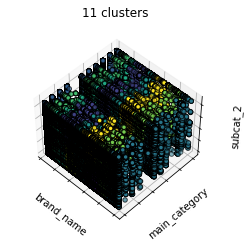

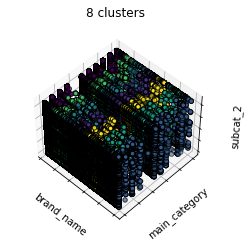

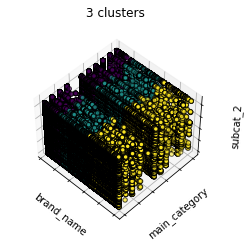

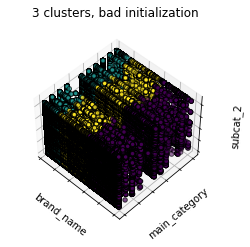

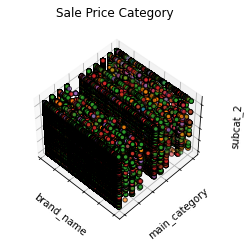

In [42]:
frame1=train_copy[['main_category','subcat_1','subcat_2','brand_name']]
frame1_name = ['main_category','subcat_1','subcat_2','brand_name']
Kmeansmethod(frame1,frame1_name)

Nhận xét: Ba hình (Hình 1, 2, 3) sử dụng model k-mean ( cluster lần lượt bằng 11, 8, 3). Ta thấy, dữ liệu được chia thành các cụm tương ứng với số cluster. Trong khi đó dữ liệu thực tế (Hình 4), các điểm dữ liệu có màu sắc tương ứng với label là khoảng giá tiền nằm ngẫu nhiên không theo một quy luật hay một cụm nào cả. Do đó, không thể lấy tính tương đồng của các điểm dữ liệu ở trong cùng một cụm để gán nhãn cụm theo nhãn (label) là khoảng giá tiền.

# **Model 4: K-NN**

In [43]:
train_encoder_price_category = train_copy.copy()
toNumeric(train_encoder_price_category, 'price_cats', 'price_cats')
train_encoder_price_category.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,subcat_1,subcat_2,log_price,price_cats
0,0,640809,3,808,4807,10.0,1,806610,5,103,763,2.302585,2
1,1,903932,3,86,3557,52.0,0,1090878,1,30,212,3.951244,3
2,2,91532,1,1254,4180,10.0,1,115289,10,104,94,2.302585,2
3,3,561143,1,485,4807,35.0,1,782305,3,55,404,3.555348,3
4,4,45483,1,1181,4807,44.0,0,366652,10,58,536,3.784190,3


In [44]:
price_cats = np.array(train_encoder_price_category.pop('price_cats'))#tách cột price_cats từ frametrain
train_encoder_price_category = train_encoder_price_category.drop(['train_id', 'price', 'category_name'] , axis=1)
train_encoder_price_category.head(5)

,name,item_condition_id,brand_name,shipping,item_description,main_category,subcat_1,subcat_2,log_price
0,640809,3,4807,1,806610,5,103,763,2.302585
1,903932,3,3557,0,1090878,1,30,212,3.951244
2,91532,1,4180,1,115289,10,104,94,2.302585
3,561143,1,4807,1,782305,3,55,404,3.555348
4,45483,1,4807,0,366652,10,58,536,3.784190


In [45]:
def Knnmethod(frametrain1,price_cats):
    frametraink1 = frametrain1.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(frametraink1, price_cats, test_size=0.20, random_state=42)
    accuracy_array = []
    k_array = []
    for k in range(1,100,3):
        knn = KNeighborsClassifier(n_neighbors=k, p = 2)
        accuracy = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')#cv = 10 fold, mặc định là 5
        accuracy_array.append(accuracy.mean())#do chia làm nhiều fold nên accurracy là một arr cần phải lấy mean
        k_array.append(k)
        
    class_error = 1.0 - np.array(accuracy_array)
    plt.plot(k_array, class_error)
    plt.xlabel('K')
    plt.ylabel('Classification Error')
    plt.show()
    min_ind = np.argmin(class_error)
    OptK = k_array[min_ind]

    accuracy_array = []
    k_array = []
    for k in range(OptK-2, OptK+2,1):
        knn = KNeighborsClassifier(n_neighbors=k)
        accuracy = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')#cv = 10 fold, mặc định là 5
        accuracy_array.append(accuracy.mean())#do chia làm nhiều fold nên accurracy là một arr cần phải lấy mean
        k_array.append(k)
    class_error = 1.0 - np.array(accuracy_array)
    plt.plot(k_array, class_error)
    plt.xlabel('K')
    plt.ylabel('Classification Error')
    plt.show()
    min_ind = np.argmin(class_error)
    OptK = k_array[min_ind]

    print ("Optimal value of K is %d " %  OptK)
    knn = KNeighborsClassifier(n_neighbors=OptK)

    # fitting the model
    knn.fit(X_train, y_train)

    # predict
    pred = knn.predict(X_test)

    # evaluate accuracy
    print("accuracy_score",accuracy_score(y_test, pred))

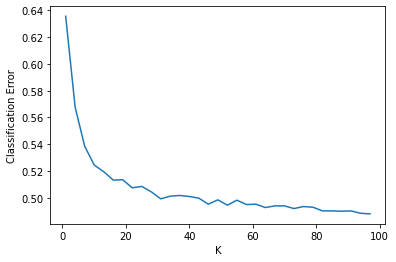

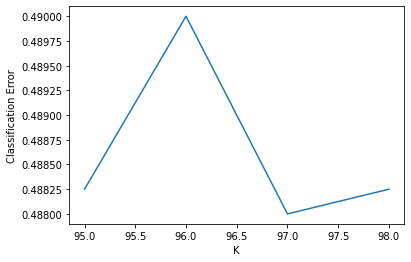

Optimal value of K is 97 
accuracy_score 0.487


In [46]:
Knnmethod(train_encoder_price_category[0:5000],price_cats[0:5000])

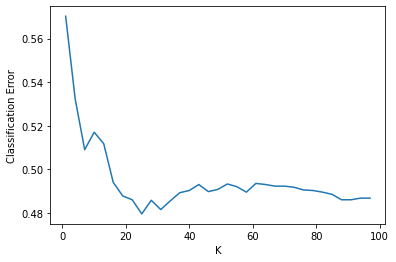

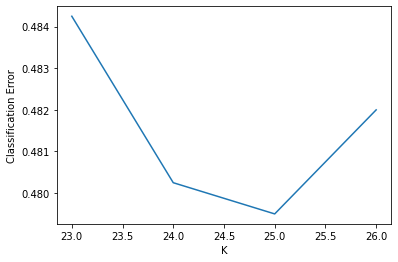

Optimal value of K is 25 
accuracy_score 0.521


In [47]:
frametrain=train_encoder_price_category[['brand_name','main_category']]
Knnmethod(frametrain[0:5000],price_cats[0:5000])

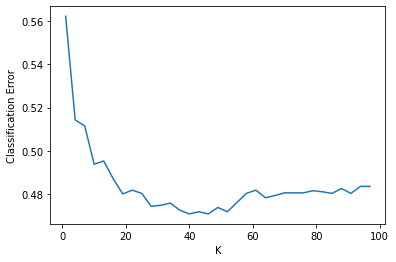

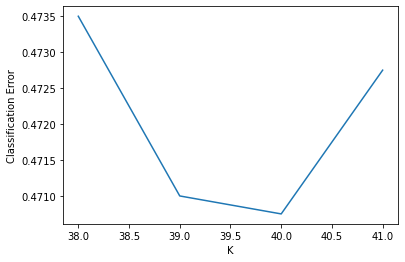

Optimal value of K is 40 
accuracy_score 0.51


In [48]:
frametrain=train_encoder_price_category[['main_category','subcat_1','brand_name']]
Knnmethod(frametrain[0:5000],price_cats[0:5000])

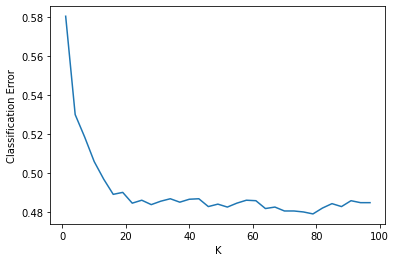

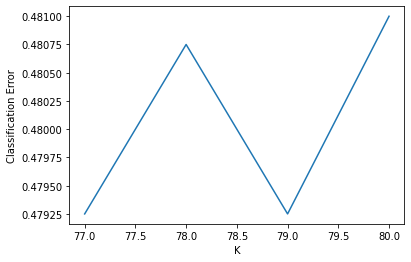

Optimal value of K is 79 
accuracy_score 0.513


In [49]:
frametrain=train_encoder_price_category[['main_category','subcat_1','subcat_2', 'item_condition_id']]
Knnmethod(frametrain[0:5000],price_cats[0:5000])

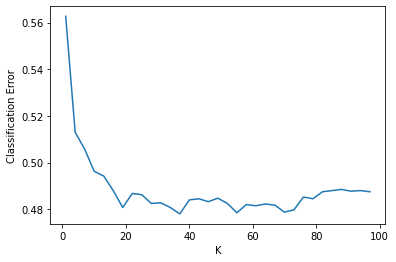

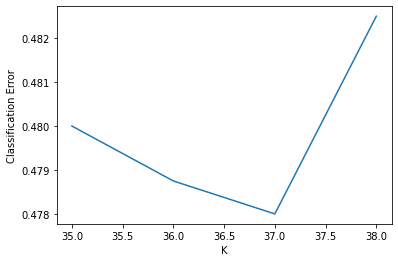

Optimal value of K is 37 
accuracy_score 0.495


In [50]:
frametrain=train_encoder_price_category[['main_category','subcat_1','subcat_2', 'item_condition_id', 'brand_name']]
Knnmethod(frametrain[0:5000],price_cats[0:5000])

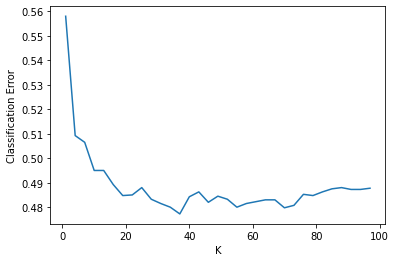

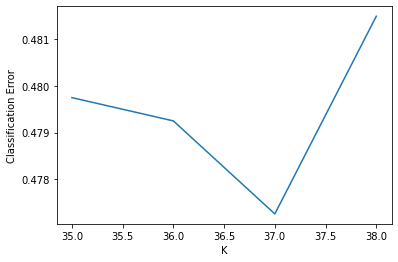

Optimal value of K is 37 
accuracy_score 0.492


In [51]:
frametrain=train_encoder_price_category[['main_category','subcat_1','subcat_2', 'item_condition_id', 'brand_name','shipping']]
Knnmethod(frametrain[0:5000],price_cats[0:5000])

Nhận xét: Khi dùng K-NN model cho tập dữ liệu, chúng tôi loại bỏ cột 'Price' và sử dụng cột 'price_cats' làm labels kết quả cho mô hình, do 2 cột này thể hiện độ tương quan cao. Sau khi áp dụng K-NN model cho tập dữ liệu, chúng tôi nhận được độ chính xác thấp, trong khoảng 0.18-0.225, giá trị chính xác cao nhất sau khi sử dụng các cột 'main_category', 'subcat_1', 'brand_name'.

# **Model 5: LogisticRegression**

In [52]:
train_encoder_price_category.head(5)

,name,item_condition_id,brand_name,shipping,item_description,main_category,subcat_1,subcat_2,log_price
0,640809,3,4807,1,806610,5,103,763,2.302585
1,903932,3,3557,0,1090878,1,30,212,3.951244
2,91532,1,4180,1,115289,10,104,94,2.302585
3,561143,1,4807,1,782305,3,55,404,3.555348
4,45483,1,4807,0,366652,10,58,536,3.784190


In [53]:
X_train_logr = train_encoder_price_category.drop(['log_price'], axis = 1)
Y_train_logr = price_cats

In [54]:
#Training
X_train, x_test, Y_train, y_test = train_test_split(
X_train_logr, Y_train_logr, test_size=0.2, random_state=42) #tách thành 2 tập test và train 

Y_train = Y_train[:, np.newaxis]  # reshape 2D array into 1D array
y_test = y_test[:, np.newaxis]  # reshape 2D array into 1D array

lr = LogisticRegression(random_state=0).fit(X_train, Y_train)


In [55]:
y_train_predict = lr.predict(X_train)
y_val_predict = lr.predict(x_test)

table = [['Score', 'Training', 'Valdation'], ['Accuracy', '{} %'.format(round((accuracy_score(Y_train, y_train_predict)*100), 2)), '{} %'.format(round((accuracy_score(y_test, y_val_predict)*100), 2))], ['F1_Score', '{} %'.format(round((f1_score(Y_train, y_train_predict, average='macro')*100))), '{} %'.format(round((f1_score(y_test, y_val_predict, average='macro')*100)))]]
print(tabulate(table, headers='firstrow', tablefmt='grid'))

+----------+------------+-------------+
| Score    | Training   | Valdation   |
+==========+============+=============+
| Accuracy | 49.74 %    | 49.6 %      |
+----------+------------+-------------+
| F1_Score | 8 %        | 8 %         |
+----------+------------+-------------+


**Có thể thấy Accuracy Score và F1_Score khi sử dụng model LogisticRegression với các class được chia theo từng khoảng giá tiền là rất thấp => Việc sử dụng model LogisticRegression theo class từng khoảng giá tiền là không hiệu quả.**

# **Step 5: Test & Output**

In [56]:
data_test_matrix = hstack(test_matrix_list).tocsr()
preds = regr_csr_matrix.predict(data_test_matrix)
np.exp(preds)
submission_data = pd.read_csv('sample_submission_stg2.csv')
submission_data.loc[:, 'price'] = np.expm1(preds)
submission_data.to_csv('submission.csv', index=False)